In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.viewer import pv
from pygimli.physics.gravimetry import MagneticsModelling

In [3]:
dim = 2000
world = mt.createWorld(start=[-dim, -dim, -dim], end=[dim, dim, 0])
# pg.show(world)

In [4]:
fault = mt.createCube(size=[1000, 400, 100], marker=2)
fault.rotate([-np.pi/2*0.8, 0, 0])
fault.translate([0, 0, -400])
fault.exportPLC("fault.poly")
geo = world + fault
pg.show(geo, style="wireframe", backend="trame")

Widget(value="<iframe src='http://localhost:59305/index.html?ui=P_0x13eb1147a00_0&reconnect=auto' style='width…

(<pyvista.plotting.plotting.Plotter at 0x13eb1147a00>, None)

In [5]:
mesh = mt.createMesh(geo, quality=1.3)
print(mesh)

Mesh: Nodes: 439 Cells: 2113 Boundaries: 4389


In [6]:
# mesh["mag"] = pg.solver.parseMapToCellArray([[1, 0], [2, 1]], mesh)
# mesh["mag"] = pg.solver.parseMapToCellArray({1: 0, 2: 1}, mesh)
# mesh.populate("mag", [[1, 0], [2, 1]])
mesh.populate("mag", {1: 0, 2: 1})  # new to v1.4.6
print(mesh)

Mesh: Nodes: 439 Cells: 2113 Boundaries: 4389
Mesh contains data: mag


In [7]:
pl, _ = pg.show(mesh, style="wireframe", hold=True, backend="trame")
pv.drawMesh(pl, mesh, style="surface", filter={"threshold": dict(value=1, scalars="mag")})
pl.show()
print(mesh)

Widget(value="<iframe src='http://localhost:59305/index.html?ui=P_0x13eb33e3d60_1&reconnect=auto' style='width…

Mesh: Nodes: 439 Cells: 2113 Boundaries: 4389
Mesh contains data: mag


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x13ed0dca2b0>)

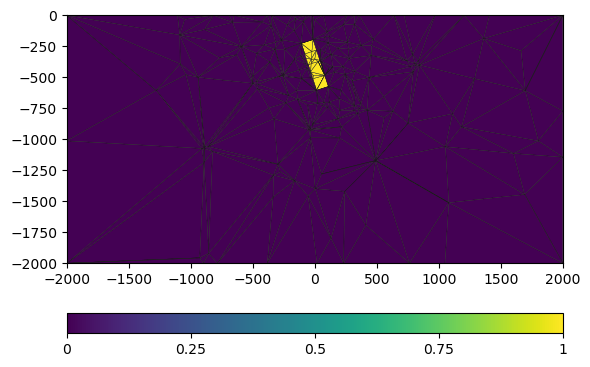

In [8]:
sli = mt.extract2dSlice(mesh, normal="x")
pg.show(sli, "mag", showMesh=True)

In [9]:
# meshNED = pg.Mesh(mesh)
# meshNED.swapCoordinates(0, 1)
# meshNED.scale([1, 1, -1])
meshNED = mesh.NED()  #creates a copy using the above commands
# pl, _ = pg.show(meshNED, style="wireframe", hold=True, backend="trame")
# pv.drawMesh(pl, meshNED, style="surface", filter={"threshold": dict(value=1, scalars="mag")})
# pl.show()

In [10]:
x = np.arange(-1000, 1001, 50)
y = np.arange(-1000, 1001, 100)
X, Y = np.meshgrid(x, y)
print(X.shape)
pnts = np.column_stack([Y.flat, X.flat, np.ones_like(X.flat)])
print(pnts.shape)

(21, 41)
(861, 3)


In [11]:
import pyIGRF
igrf = pyIGRF.igrf_value(lat=50.59465, lon=12.64139, alt=0.0)  # alt in km!
print(np.transpose(igrf))

[1.82487977e+00 6.62570748e+01 1.96114146e+04 1.96014682e+04
 6.24521099e+02 4.45852635e+04 4.87078362e+04]


Wolfram alpha says T=49.5µT, X/Y/Z=19.6/1.56/45.4µT, so what's wrong?

In [12]:
pnts[:, 2] = -80
cmp = ["TFA", "Bx", "By", "Bz", "Bxx", "Bxy", "Bxz", "Byy", "Byz", "Bzz"]
fop = MagneticsModelling(meshNED, pnts, igrf=igrf, cmp=cmp)

   0%|          |0/861 [00:00 < ?]

In [13]:
out = fop.response(mesh["mag"]*0.05)
fields = np.reshape(out, [len(cmp), -1])

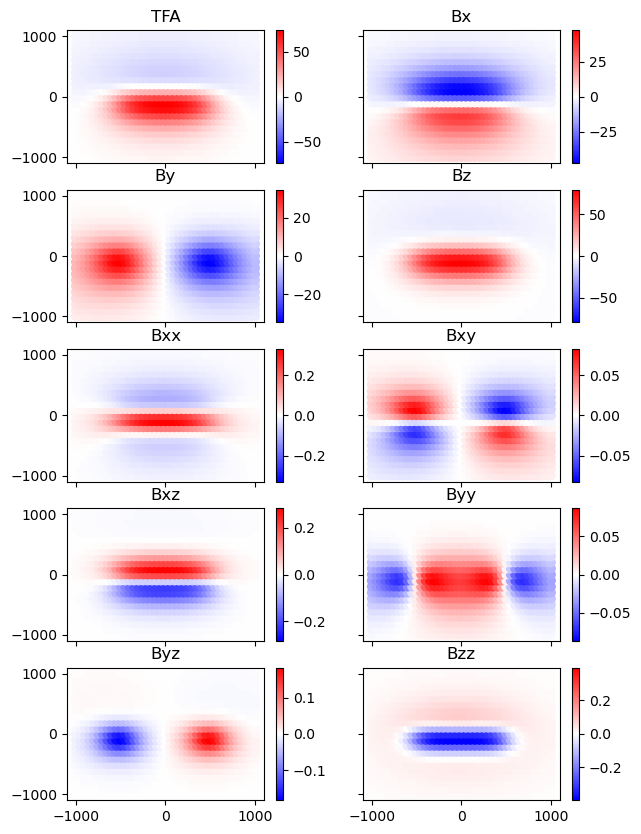

In [14]:
fig, ax = plt.subplots(len(cmp)//2, 2, sharex=True, sharey=True, figsize=(7, 10))
for i in range(len(cmp)):
    fld = fields[i]
    vv = max(-min(fld), max(fld))
    sc = ax.flat[i].scatter(X.flat, Y.flat, c=fld, cmap="bwr", vmin=-vv, vmax=vv)
    ax.flat[i].set_title(cmp[i])
    fig.colorbar(sc, ax=ax.flat[i])

In [15]:
headerline = "x      \ty       \tz       \t"+"      \t".join(cmp)
A = np.hstack([pnts*np.reshape([1, 1, -1], [1, 3]), fields.T])
np.savetxt("fault-synth.mag", A, header=headerline, delimiter="\t", fmt="%7.3e")